# Import

In [14]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt
from scipy.stats import mode
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import optuna
from optuna.samplers import TPESampler

# About Dataset
- Sample Rate = 25Hz
- Duration = 20 mins
- AF = 19 respondent
- Non-AF = 16 respondent
- n_data per pasien = 25Hz * (20m * 60s) = 30000 data per pasien
- Total data = 30000 * 35 pasien = 1050000. Tapi detik ke-0 juga diitung jadi = 1050035

In [ ]:
# df = pd.read_csv(r'/kaggle/input/mimic-perform-iii-af-and-non-af-dataset/ppg_af_dataset.csv')
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..', '..'))
file_path = os.path.join(project_root, 'Data', 'ppg_af_dataset.csv')

print(f"file dari: {file_path}")

df = pd.read_csv(file_path)
df

file dari: c:\Users\Lenovo\Documents\GitHub\FP_MLxDM\Data\ppg_af_dataset.csv


,time,ppg,ecg,resp,status
0,0.000,0.410557,0.314453,0.717097,0
1,0.008,0.400782,0.285156,0.720787,0
2,0.016,0.391007,0.300781,0.723247,0
3,0.024,0.382209,0.304688,0.726937,0
4,0.032,0.372434,0.294922,0.730627,0
...,...,...,...,...,...
5250030,1199.968,0.472141,-0.189453,0.331378,1
5250031,1199.976,0.473118,-0.498047,0.334311,1
5250032,1199.984,0.474096,-0.498047,0.337243,1
5250033,1199.992,0.474096,-0.359375,0.340176,1


# EDA

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250035 entries, 0 to 5250034
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    float64
 1   ppg     float64
 2   ecg     float64
 3   resp    float64
 4   status  int64  
dtypes: float64(4), int64(1)
memory usage: 200.3 MB


In [17]:
df.describe()

,time,ppg,ecg,resp,status
count,5.250035e+06,5.247136e+06,5.249660e+06,3.900026e+06,5.250035e+06
mean,6.000000e+02,9.497512e-01,4.150870e-01,2.368876e-01,5.428571e-01
std,3.464125e+02,7.359953e-01,2.779199e-01,4.592674e-01,4.981599e-01
min,0.000000e+00,0.000000e+00,-5.019608e-01,-1.846506e+00,0.000000e+00
25%,3.000000e+02,4.078431e-01,2.649071e-01,2.015883e-02,0.000000e+00
50%,6.000000e+02,5.503421e-01,4.257812e-01,2.355816e-01,1.000000e+00
75%,9.000000e+02,1.678397e+00,5.551758e-01,4.686347e-01,1.000000e+00
max,1.200000e+03,4.001955e+00,1.503937e+00,2.844215e+00,1.000000e+00


In [18]:
status_count = df['status'].value_counts()
status_count

status
1    2850019
0    2400016
Name: count, dtype: int64

## Pie chart AF Status

In [19]:
# Pie chart (for percentage)
status = status_count.sort_index()
status_index = status.index
fig = px.pie(names=status_index, values=status, hole=0.3,
             labels={'names':'status'}, title='AF Status Distribution Pie Chart')
fig.update_traces(textposition='inside', textinfo='percent+label+value')
fig.show()


In [20]:
# df125.isna().sum()
df.isna().sum()

time            0
ppg          2899
ecg           375
resp      1350009
status          0
dtype: int64

In [21]:
# df125.isna().mean() * 100
df.isna().mean() * 100

time       0.000000
ppg        0.055219
ecg        0.007143
resp      25.714286
status     0.000000
dtype: float64

## Visualize signal on specific range

In [22]:
def show_wave_from(df, pasien_ke=1, s_start=0, s_stop=10, fitur='ppg', af_status=0, sample_rate=125):
    lama_ukur = 1200 # 20m = 1200s
    sample_per_pasien = lama_ukur * sample_rate
    duration = s_stop - s_start

    if 0 <= s_start <= lama_ukur and 0 <= s_stop <= lama_ukur:
        if af_status == 0 and 1 <= pasien_ke <= 16:
            afdf = df[df['status'] == 0]
        elif af_status == 1 and 1 <= pasien_ke <= 19:
            afdf = df[df['status'] == 1]
        else:
            print('Invalid nomor pasien atau sample time')

        dfpasien = afdf[(pasien_ke - 1) * sample_per_pasien : pasien_ke * sample_per_pasien]
        dfintvl = dfpasien[sample_rate*s_start : (sample_rate*s_stop)+1]
            
        x_ax = dfintvl['time']
        y_ax = dfintvl[fitur]

        plt.figure(figsize=(16, 4))
        plt.plot(x_ax, y_ax)
        plt.title(f'Gelombang {fitur} dari pasien ke-{pasien_ke} dari {s_start} - {s_stop} detik')

        step = s_start
        for t in range(duration):
            step += 1
            plt.axvline(x=step, color='gray', linestyle='--', linewidth=0.8)

        plt.show()

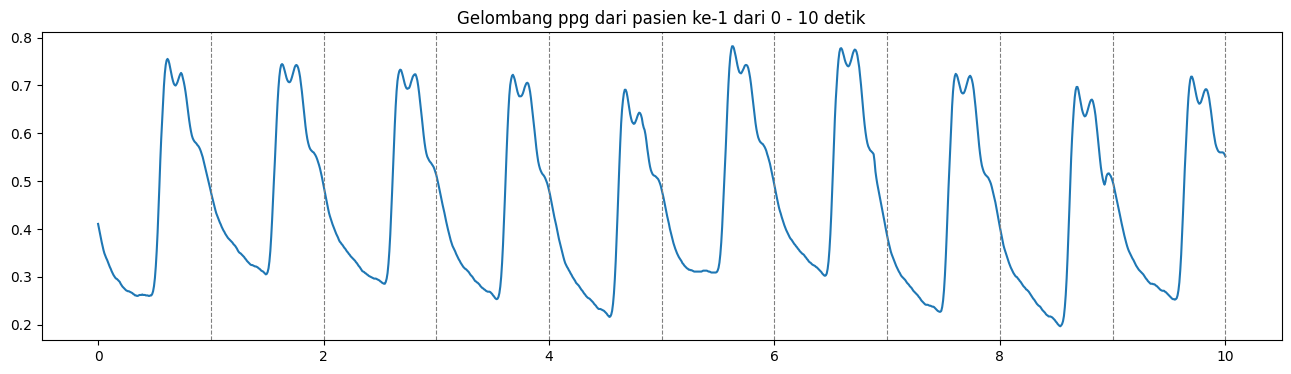

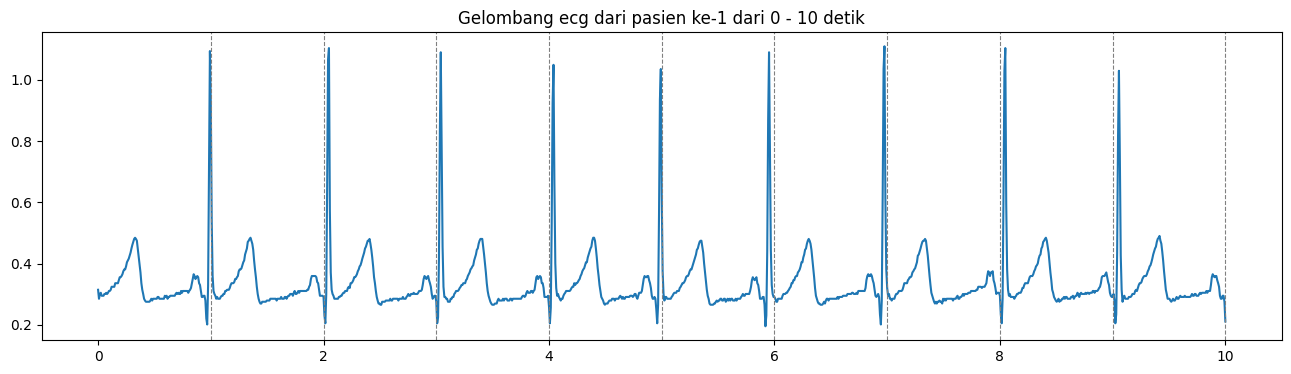

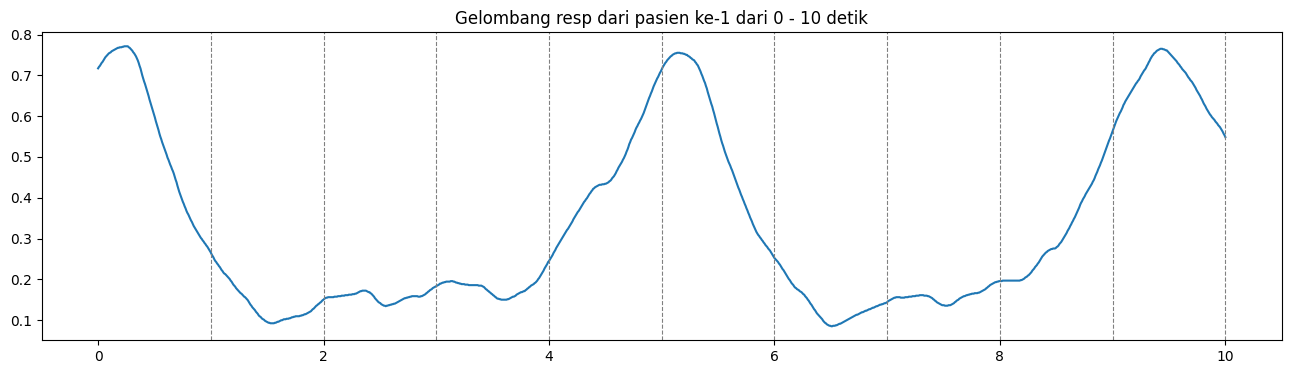

In [23]:
for i in df.columns[1:-1]:
    show_wave_from(df, fitur=i, sample_rate=125)

## AF VS Non-AF Wave

Non-AF Wave:


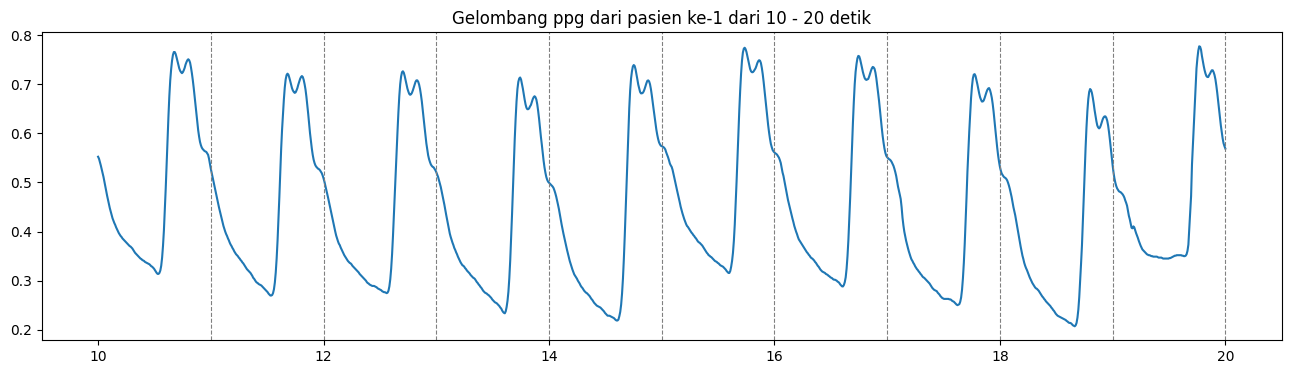

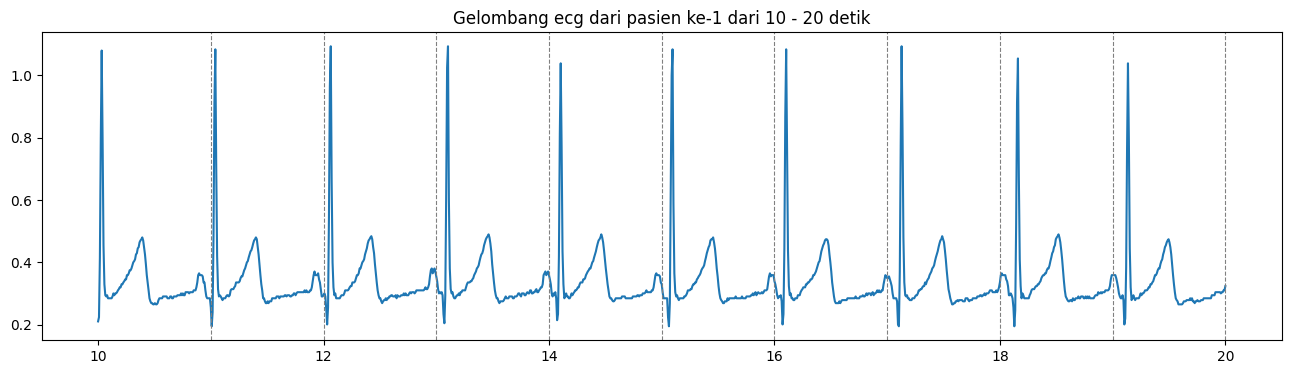

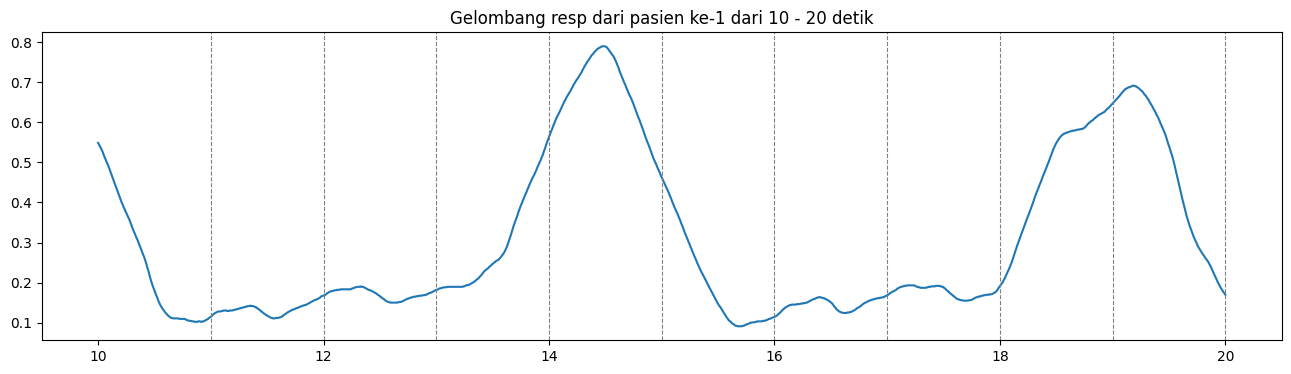

AF Wave:


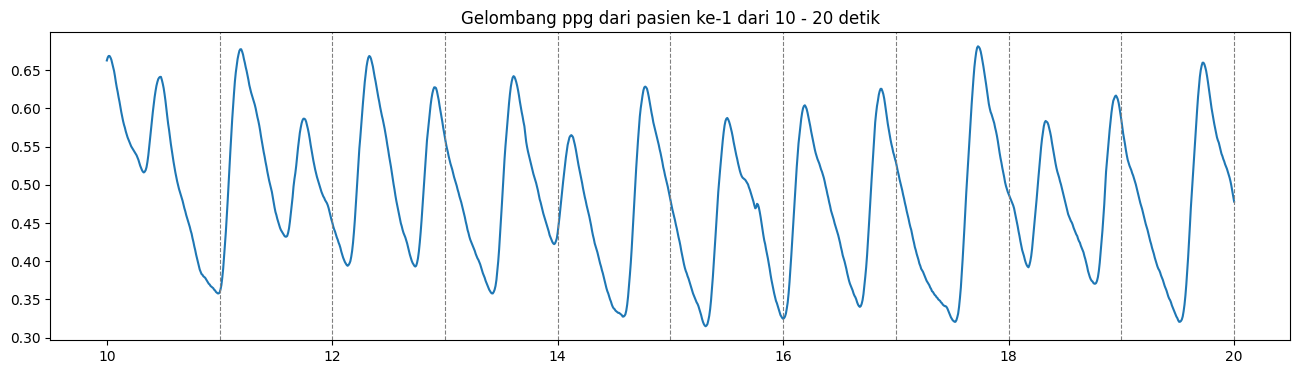

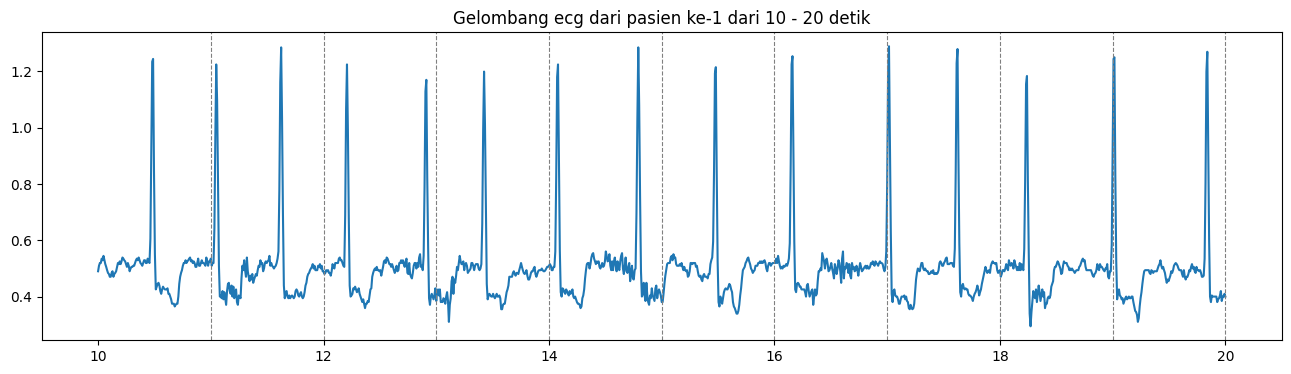

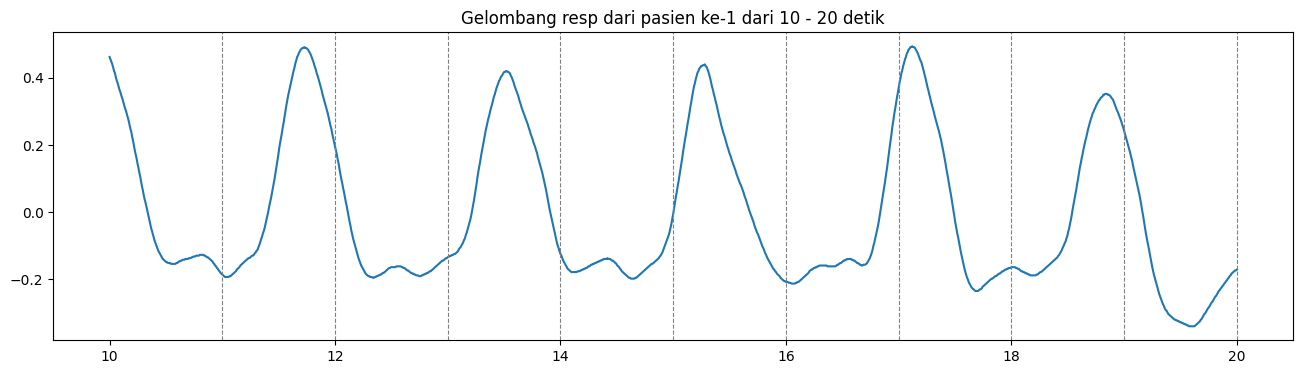

In [24]:
print('Non-AF Wave:')
for i in df.columns[1:-1]:
    show_wave_from(df, sample_rate=125, pasien_ke=1, s_start=10, s_stop=20, af_status=0, fitur=i)

print('AF Wave:')
for i in df.columns[1:-1]:
    show_wave_from(df, sample_rate=125, pasien_ke=1, s_start=10, s_stop=20, af_status=1, fitur=i)

# Praprocessing

## Imputation: Interpolation

In [25]:
df['ppg'] = df['ppg'].interpolate()
df['ecg'] = df['ecg'].interpolate()
df['resp'] = df['resp'].interpolate()

df.isna().sum()

time      0
ppg       0
ecg       0
resp      0
status    0
dtype: int64

## Set Window Size

In [26]:
sampling_rate = 125
window_size = sampling_rate    # 125 segment per window
n_features = 3  # PPG, ECG, and RESP

# Extract PPG, ECG, and RESP signals
ppg_signal = df['ppg'].values
ecg_signal = df['ecg'].values
resp_signal = df['resp'].values
n_windows = len(ppg_signal) // window_size

# Create windows for all three features
windows_list = []
for i in range(n_windows):
    start = i * window_size
    end = start + window_size
    ppg_window = ppg_signal[start:end]
    ecg_window = ecg_signal[start:end]
    resp_window = resp_signal[start:end]
    # Stack PPG, ECG, and RESP as separate features
    combined_window = np.column_stack([ppg_window, ecg_window, resp_window])
    windows_list.append(combined_window)

# Convert to array: shape will be (n_windows, 125, 3)
windows_array = np.array(windows_list)
print(f"Windows shape: {windows_array.shape}")

# Flatten for DataFrame storage: each row = 375 values (125*3)
df_window = pd.DataFrame(windows_array.reshape(n_windows, -1))
df_window

Windows shape: (42000, 125, 3)


,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
0,0.410557,0.314453,0.717097,0.400782,0.285156,0.720787,0.391007,0.300781,0.723247,0.382209,...,0.280443,0.503421,0.330078,0.276753,0.494624,0.708984,0.273063,0.486804,1.093750,0.269373
1,0.478006,0.919922,0.265683,0.470186,0.539062,0.260763,0.462366,0.359375,0.257073,0.454545,...,0.142681,0.519062,0.294922,0.143911,0.510264,0.294922,0.146371,0.500489,0.294922,0.148831
2,0.490714,0.291016,0.150062,0.480938,0.230469,0.152522,0.470186,0.205078,0.153752,0.460411,...,0.178352,0.529814,0.291016,0.179582,0.524927,0.294922,0.180812,0.519062,0.294922,0.182042
3,0.513196,0.275391,0.183272,0.505376,0.205078,0.184502,0.496579,0.224609,0.185732,0.487781,...,0.230012,0.500489,0.291016,0.233702,0.495601,0.291016,0.237392,0.488759,0.294922,0.242312
4,0.480938,0.259766,0.244772,0.473118,0.205078,0.248462,0.463343,0.255859,0.252153,0.454545,...,0.696187,0.500489,0.560547,0.701107,0.495601,0.935547,0.706027,0.489736,1.035156,0.709717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0.456500,0.115234,0.420332,0.451613,0.111328,0.423265,0.448680,0.105469,0.427175,0.444770,...,0.374389,0.531769,0.166016,0.375367,0.520039,0.166016,0.376344,0.511241,0.160156,0.376344
41996,0.504399,0.160156,0.377322,0.498534,0.160156,0.379277,0.492669,0.175781,0.380254,0.488759,...,0.268817,0.372434,0.140625,0.260997,0.372434,0.134766,0.253177,0.371457,0.134766,0.246334
41997,0.371457,0.134766,0.239492,0.371457,0.134766,0.232649,0.371457,0.130859,0.226784,0.371457,...,0.115347,0.592375,-0.029297,0.113392,0.590420,-0.224609,0.112414,0.586510,-0.498047,0.110459
41998,0.581623,-0.498047,0.109482,0.575758,-0.349609,0.107527,0.567937,-0.148438,0.106549,0.560117,...,0.368524,0.393939,0.140625,0.366569,0.391007,0.156250,0.365591,0.390029,0.144531,0.363636


In [27]:
# jml kolom
len(df_window.iloc[0,:])

375

### Visualisasi

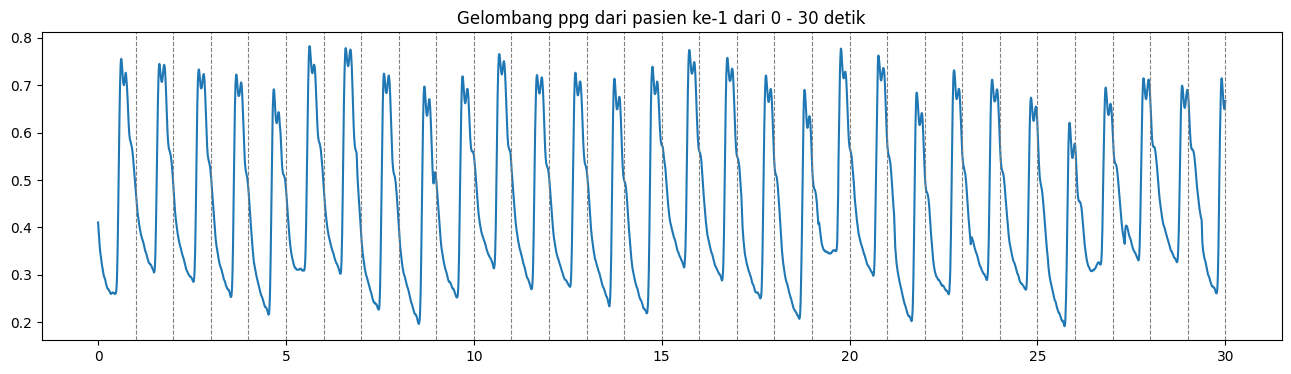

In [28]:
# Visualize ppg 30s (1 row df_window)
show_wave_from(df, sample_rate=125, s_start=0, s_stop=30)

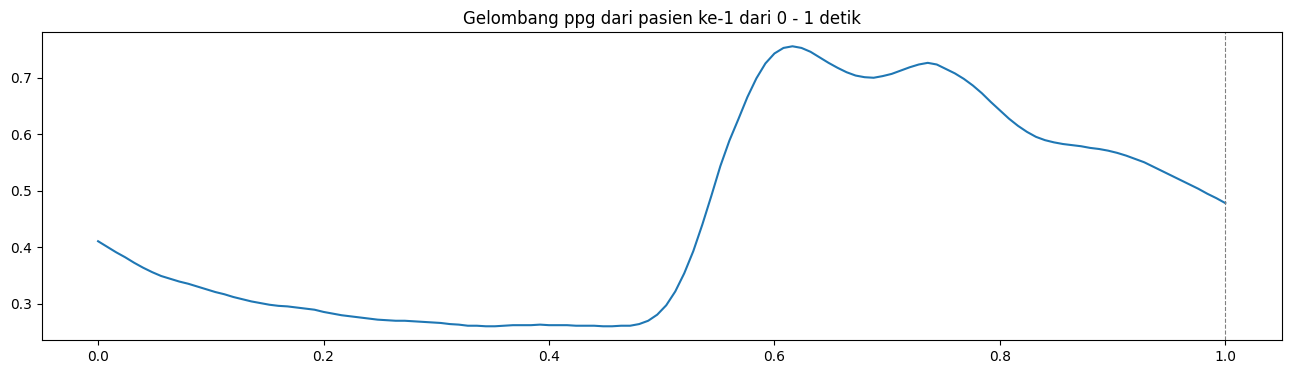

In [29]:
show_wave_from(df, sample_rate=125, s_start=0, s_stop=1)

## Add Label

In [30]:
status_array = df['status'].values
df_label = []

# Vote majority label per window
for i in range(n_windows):
    start = i * window_size
    end = start + window_size
    window_status = status_array[start:end]
    label = mode(window_status, keepdims=False).mode
    df_label.append(label)

df_label = pd.Series(df_label)
df_label

0        0
1        0
2        0
3        0
4        0
        ..
41995    1
41996    1
41997    1
41998    1
41999    1
Length: 42000, dtype: int64

In [31]:
df_label[df_label==1]

19200    1
19201    1
19202    1
19203    1
19204    1
        ..
41995    1
41996    1
41997    1
41998    1
41999    1
Length: 22800, dtype: int64

## Train Test Split

In [32]:
train_size = int(len(df_window) * 0.7)
val_size = int(len(df_window) * 0.15)

X_train = df_window[:train_size]
y_train = df_label[:train_size]

X_val = df_window[train_size: train_size + val_size]
y_val = df_label[train_size: train_size + val_size]

X_test = df_window[train_size + val_size:]
y_test = df_label[train_size + val_size:]

## Preprocess Pipeline

In [33]:
# Reshape data to 3D format (n_samples, 125, 3)
# Data now has 375 columns (125 timesteps * 3 features: PPG, ECG, RESP)
X_train_prep = X_train.values.reshape(-1, 125, 3)
X_val_prep = X_val.values.reshape(-1, 125, 3)
X_test_prep = X_test.values.reshape(-1, 125, 3)

print(f"X_train shape: {X_train_prep.shape}")
print(f"X_val shape: {X_val_prep.shape}")
print(f"X_test shape: {X_test_prep.shape}")
print(f"\n✅ Data contains PPG, ECG, and RESP (3 features)")

X_train shape: (29399, 125, 3)
X_val shape: (6300, 125, 3)
X_test shape: (6301, 125, 3)

✅ Data contains PPG, ECG, and RESP (3 features)


In [34]:
# Transformer buat reshape 2D jadi 3D (updated for 3 features)
class ReshapeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_timesteps=125, n_features=3):
        self.n_timesteps = n_timesteps
        self.n_features = n_features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # reshape jadi 3D: (n_samples, n_timesteps, n_features)
        if isinstance(X, pd.DataFrame):
            X = X.values
        return np.reshape(X, (X.shape[0], self.n_timesteps, self.n_features))

In [35]:
X_train_prep.shape

(29399, 125, 3)

# Ekstraksi Fitur

## LSTM Model untuk Ekstraksi Fitur

In [36]:
def build_model(n_timesteps=125, n_features=3):
    """Build LSTM model for PPG, ECG, and RESP signals"""
    model = Sequential([
        Input(shape=(n_timesteps, n_features)),
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'recall'])
    return model

In [ ]:
# Train LSTM model
model = build_model(n_timesteps=125, n_features=3)
tf.compat.v1.enable_eager_execution()
history = model.fit(
    X_train_prep, y_train,
    epochs=60,
    batch_size=64,
    validation_data=(X_val_prep, y_val),
    verbose=1
)
print(f"Training completed. Final val_loss: {history.history['val_loss'][-1]:.4f}")


Epoch 1/60
460/460 ━━━━━━━━━━━━━━━━━━━━ 94s 190ms/step - accuracy: 0.7628 - loss: 0.4822 - recall: 0.5851 - val_accuracy: 0.0421 - val_loss: 1.4479 - val_recall: 0.0421
Epoch 2/60
460/460 ━━━━━━━━━━━━━━━━━━━━ 86s 186ms/step - accuracy: 0.7818 - loss: 0.4678 - recall: 0.6284 - val_accuracy: 0.0306 - val_loss: 2.1121 - val_recall: 0.0306
Epoch 3/60
460/460 ━━━━━━━━━━━━━━━━━━━━ 87s 189ms/step - accuracy: 0.7322 - loss: 0.5095 - recall: 0.6985 - val_accuracy: 0.0578 - val_loss: 1.0938 - val_recall: 0.0578
Epoch 4/60
460/460 ━━━━━━━━━━━━━━━━━━━━ 92s 198ms/step - accuracy: 0.7743 - loss: 0.4615 - recall: 0.4998 - val_accuracy: 0.0698 - val_loss: 2.0448 - val_recall: 0.0698
Epoch 5/60
460/460 ━━━━━━━━━━━━━━━━━━━━ 86s 187ms/step - accuracy: 0.7684 - loss: 0.4526 - recall: 0.5166 - val_accuracy: 0.0030 - val_loss: 1.7279 - val_recall: 0.0030
Epoch 6/60
460/460 ━━━━━━━━━━━━━━━━━━━━ 85s 182ms/step - accuracy: 0.7958 - loss: 0.4381 - recall: 0.5709 - val_accuracy: 0.0571 - val_loss: 1.7828 - val_

In [ ]:
# Save trained LSTM model
os.makedirs('models/SVM', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
model_path = f'models/SVM/lstm_ppg_ecg_resp_{timestamp}.h5'
model.save(model_path)
print(f'LSTM model saved as: {model_path}')

LSTM model saved as: models/lstm_ppg_ecg_resp_03122025_192437.h5


## Visualisasi Hasil

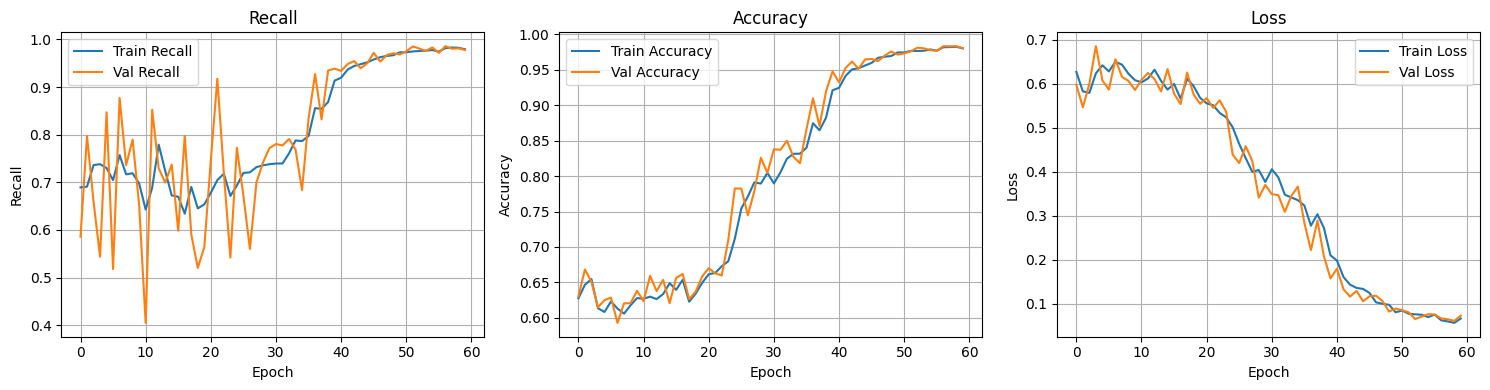

In [ ]:
# Plot training history
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Build Feature Extractor dari LSTM yang sudah dilatih
# Menggunakan output dari last dense layer (Dense 32) sebagai fitur
lstm_last_dense = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print("✅ LSTM Feature Extractor created")
lstm_last_dense.summary()

✅ LSTM Feature Extractor created


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 125, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,488 (76.12 KB)

 Trainable params: 19,488 (76.12 KB)

 Non-trainable params: 0 (0.00 B)

## Ekstraksi Fitur dari LSTM

In [ ]:
# Extract features menggunakan LSTM feature extractor
# Output: 32 fitur dari last dense layer untuk setiap sampel
X_train_xtract = lstm_last_dense.predict(X_train_prep)
X_val_xtract = lstm_last_dense.predict(X_val_prep)
X_test_xtract = lstm_last_dense.predict(X_test_prep)

print(f"✅ Extracted features shape:")
print(f"   Train: {X_train_xtract.shape}")
print(f"   Val: {X_val_xtract.shape}")
print(f"   Test: {X_test_xtract.shape}")
print(f"   Features extracted from 3 physiological signals (PPG, ECG, RESP)")

919/919 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
✅ Extracted features shape:
   Train: (29400, 32)
   Val: (6300, 32)
   Test: (6300, 32)
   Features extracted from 3 physiological signals (PPG, ECG, RESP)


# Classifier

## Hyperparameter Tuning dengan Grid Search

### Tuning

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'degree': [2, 3, 4],            # relevan untuk kernel='poly'
    'class_weight': [None, 'balanced']
}

In [ ]:
svc = SVC(random_state=77)  # probability=False by default
model_grid = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='accuracy',   # atau 'f1'/'recall' jika lebih cocok untuk dataset imbalance
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [ ]:
print("Starting GridSearchCV...")
model_grid.fit(X_train_xtract, y_train)
print("GridSearchCV Done")

Starting GridSearchCV...
Fitting 3 folds for each of 600 candidates, totalling 1800 fits
GridSearchCV Done


In [ ]:
print("Best params:", model_grid.best_params_)
print("Skor cross-validation terbaik:", model_grid.best_score_)

best_params_grid = model_grid.best_params_

NameError: name 'model_grid' is not defined

### Run Model

In [ ]:
model_grid = SVC(**best_params_grid, probability=True, random_state=77)
model_grid.fit(X_train_xtract, y_train)

,C,100
,kernel,'poly'
,degree,2
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [ ]:
y_pred_best_grid = model_grid.predict(X_test_xtract)
y_prob_best_grid = model_grid.decision_function(X_test_xtract)

## Evaluasi Model GridSearch CV

### Metrik Evaluasi

In [ ]:
acc_grid = accuracy_score(y_test, y_pred_best_grid)
prec_grid = precision_score(y_test, y_pred_best_grid)
rec_grid = recall_score(y_test, y_pred_best_grid)
f1s_grid = f1_score(y_test, y_pred_best_grid)
rocauc_grid = roc_auc_score(y_test, y_prob_best_grid)

print("Evaluasi Best SVC")
print(f"Accuracy:  {acc_grid:.4f}")
print(f"Precision: {prec_grid:.4f}")
print(f"Recall:    {rec_grid:.4f}")
print(f"F1 Score:  {f1s_grid:.4f}")
print(f"ROC AUC:   {rocauc_grid:.4f}\n")

print(classification_report(y_test, y_pred_best_grid))

Evaluasi Best SVC
Accuracy:  0.9862
Precision: 0.9903
Recall:    0.9842
F1 Score:  0.9872
ROC AUC:   0.9951

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2880
           1       0.99      0.98      0.99      3420

    accuracy                           0.99      6300
   macro avg       0.99      0.99      0.99      6300
weighted avg       0.99      0.99      0.99      6300



### ROC Curve

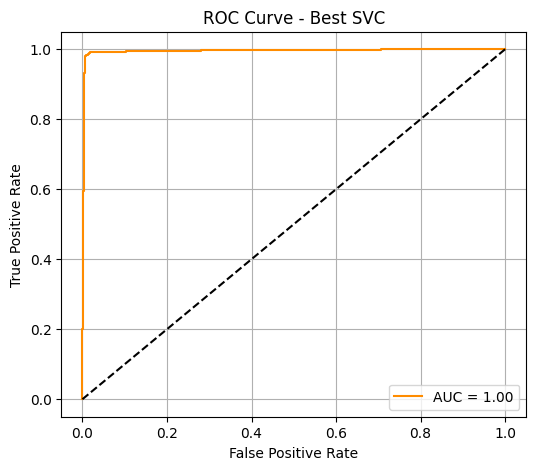

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob_best_grid)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {rocauc_grid:.2f}", color='darkorange')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best SVC')
plt.legend()
plt.grid(True)
plt.show()

### Confusion matrix

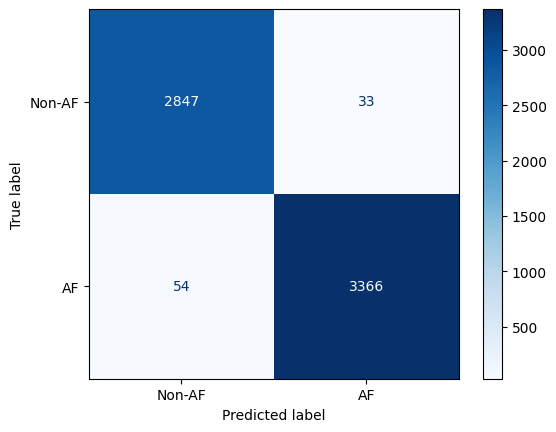

In [ ]:
cm = confusion_matrix(y_test, y_pred_best_grid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF','AF'])
disp.plot(cmap='Blues')
plt.show()

## Hyperparameter Tuning dengan Optuna

### Tuning

In [ ]:
def objective(trial):
    # Define hyperparameter search space
    param = {
        'C': trial.suggest_float('C', 0.01, 100, log=True),
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto', 0.001, 0.01, 0.1]),
        'degree': trial.suggest_int('degree', 2, 4),  # untuk kernel poly
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': 77
    }
    
    # Train model
    svc_optuna = SVC(**param)
    svc_optuna.fit(X_train_xtract, y_train)
    
    # Evaluate on validation set
    y_pred_val = svc_optuna.predict(X_val_xtract)
    accuracy = accuracy_score(y_val, y_pred_val)
    
    return accuracy

# Create study and optimize
print("Starting Optuna optimization...")
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=77)
)
study.optimize(objective, n_trials=100, show_progress_bar=True)
print("Optuna optimization Done")

[I 2025-12-03 19:39:08,584] A new study created in memory with name: no-name-f8d16a77-fd57-48ed-bd30-354db9421373


Starting Optuna optimization...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-03 19:39:18,051] Trial 0 finished with value: 0.9814285714285714 and parameters: {'C': 47.47184677446414, 'kernel': 'linear', 'gamma': 'scale', 'degree': 3, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9814285714285714.
[I 2025-12-03 19:39:18,972] Trial 1 finished with value: 0.9815873015873016 and parameters: {'C': 2.25904337744176, 'kernel': 'poly', 'gamma': 'auto', 'degree': 2, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9815873015873016.
[I 2025-12-03 19:39:23,601] Trial 2 finished with value: 0.9806349206349206 and parameters: {'C': 0.017992275660414364, 'kernel': 'sigmoid', 'gamma': 0.001, 'degree': 3, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9815873015873016.
[I 2025-12-03 19:39:24,407] Trial 3 finished with value: 0.9822222222222222 and parameters: {'C': 0.3489913256264903, 'kernel': 'linear', 'gamma': 'scale', 'degree': 3, 'class_weight': None}. Best is trial 3 with value: 0.9822222222222222.
[I 2025-12-03 19:39:25,285]

In [ ]:
best_params_optuna = study.best_params
best_score = study.best_value

print(best_params_optuna)
print(best_score)

{'C': 0.3489913256264903, 'kernel': 'linear', 'gamma': 'scale', 'degree': 3, 'class_weight': None}
0.9822222222222222


### Run Model

In [ ]:
model_optuna = SVC(**best_params_optuna)
model_optuna.fit(X_train_xtract, y_train)

,C,0.3489913256264903
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [ ]:
y_prob_optuna = model_optuna.decision_function(X_test_xtract)
y_pred_optuna = model_optuna.predict(X_test_xtract)
y_prob_optuna

array([ 3.22727971,  2.40864891, -2.02441353, ..., -1.25674477,
        1.58201733,  2.16383038], shape=(6300,))

## Evaluasi Model Optuna

### Metrik Evaluasi

In [ ]:
acc_optuna = accuracy_score(y_test, y_pred_optuna)
prec_optuna = precision_score(y_test, y_pred_optuna)
recall_optuna = recall_score(y_test, y_pred_optuna)
f1_optuna = f1_score(y_test, y_pred_optuna)
rocauc_optuna = roc_auc_score(y_test, y_prob_optuna)

print('SVC Evaluation (raw)')
print(f'Accuracy: {acc_optuna:.4f}')
print(f'Precision: {prec_optuna:.4f}')
print(f'Recall   : {recall_optuna:.4f}')
print(f'F1 Score : {f1_optuna:.4f}')
print(f'ROC AUC  : {rocauc_optuna:.4f}')

print(classification_report(y_test, y_pred_optuna))


SVC Evaluation (raw)
Accuracy: 0.9860
Precision: 0.9897
Recall   : 0.9845
F1 Score : 0.9871
ROC AUC  : 0.9961
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2880
           1       0.99      0.98      0.99      3420

    accuracy                           0.99      6300
   macro avg       0.99      0.99      0.99      6300
weighted avg       0.99      0.99      0.99      6300



### ROC Curve

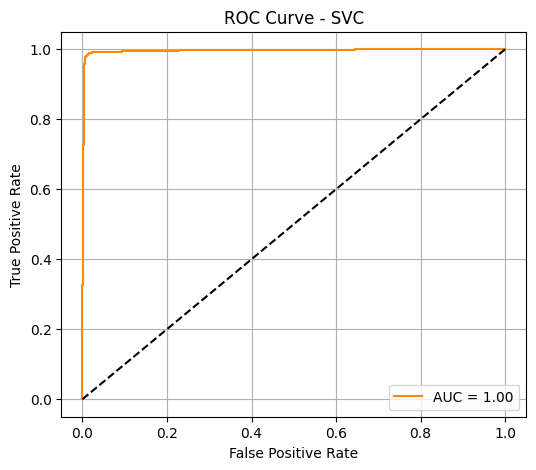

In [ ]:
# ROC curve for raw SVC
fpr, tpr, _ = roc_curve(y_test, y_prob_optuna)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {rocauc_optuna:.2f}", color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC')
plt.legend()
plt.grid(True)
plt.show()

### Confusion Matrix

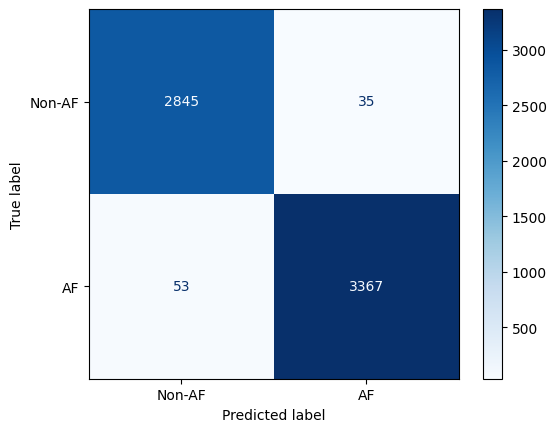

In [ ]:
# Confusion matrix hybrid
cm = confusion_matrix(y_test, y_pred_optuna)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF', 'AF'])
disp_cm.plot(cmap='Blues')

## Tanpa Hyperparameter Tuning

### Run Model

In [ ]:
model_raw = SVC()

model_raw.fit(X_train_xtract, y_train)
model_raw

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [ ]:
y_prob_raw = model_raw.decision_function(X_test_xtract)
y_pred_raw = model_raw.predict(X_test_xtract)
y_prob_raw

array([ 1.05684708,  1.09972779, -1.03117301, ..., -1.0880427 ,
        1.07544304,  1.2337493 ], shape=(6300,))

## Evaluasi Model Tanpa Hyperparamater Tuning

### Metrik Evaluasi

In [ ]:
acc_raw = accuracy_score(y_test, y_pred_raw)
prec_raw = precision_score(y_test, y_pred_raw)
recall_raw = recall_score(y_test, y_pred_raw)
f1_raw = f1_score(y_test, y_pred_raw)
rocauc_raw = roc_auc_score(y_test, y_prob_raw)

print('SVC Evaluation (raw)')
print(f'Accuracy: {acc_raw:.4f}')
print(f'Precision: {prec_raw:.4f}')
print(f'Recall   : {recall_raw:.4f}')
print(f'F1 Score : {f1_raw:.4f}')
print(f'ROC AUC  : {rocauc_raw:.4f}')

print(classification_report(y_test, y_pred_raw))


SVC Evaluation (raw)
Accuracy: 0.9857
Precision: 0.9891
Recall   : 0.9845
F1 Score : 0.9868
ROC AUC  : 0.9904
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2880
           1       0.99      0.98      0.99      3420

    accuracy                           0.99      6300
   macro avg       0.99      0.99      0.99      6300
weighted avg       0.99      0.99      0.99      6300



### ROC Curve

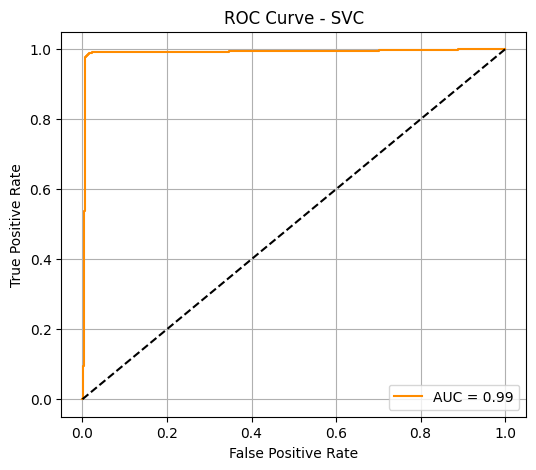

In [ ]:
# ROC curve for raw SVC
fpr, tpr, _ = roc_curve(y_test, y_prob_raw)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {rocauc_raw:.2f}", color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC')
plt.legend()
plt.grid(True)
plt.show()

### Confusion Matrix

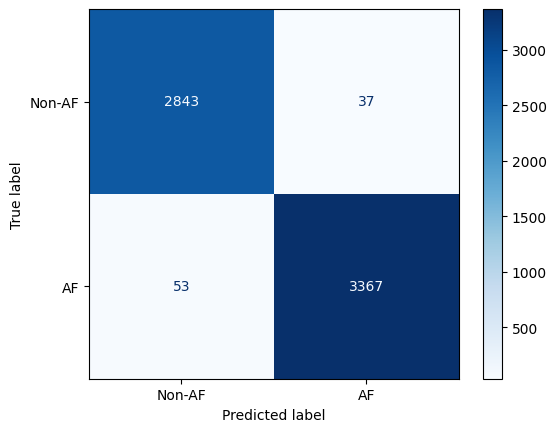

In [ ]:
# Confusion matrix hybrid
cm = confusion_matrix(y_test, y_pred_raw)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-AF', 'AF'])
disp_cm.plot(cmap='Blues')

# Evaluasi

## Histogram Perbandingan Accuracy

In [ ]:
try:
    acc_dict = {
        'GridSearchCV': acc_grid,
        'Optuna': acc_optuna,
        'No Tuning': acc_raw
    }
except NameError:
    acc_dict = {}
    if 'y_pred_best_grid' in globals():
        acc_dict['GridSearchCV'] = accuracy_score(y_test, y_pred_best_grid)
    if 'y_pred_optuna' in globals():
        acc_dict['Optuna'] = accuracy_score(y_test, y_pred_optuna)
    if 'y_pred_raw' in globals():
        acc_dict['No Tuning'] = accuracy_score(y_test, y_pred_raw)

if not acc_dict:
    raise RuntimeError("Accuracies not available. Jalankan cell evaluasi model terlebih dahulu.")

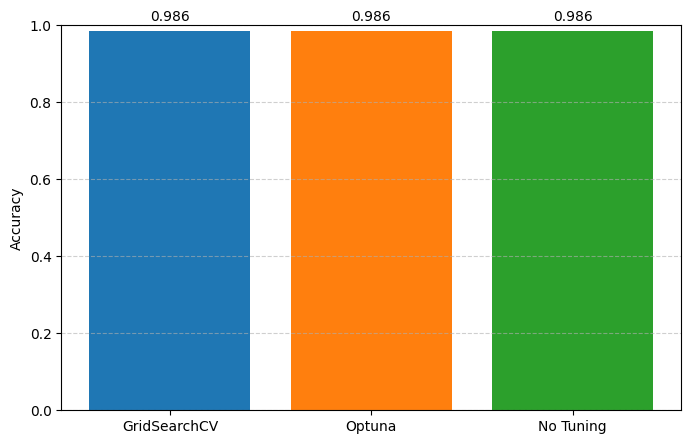

In [ ]:
# Plot
acc_series = pd.Series(acc_dict)
acc_series = acc_series.reindex(['GridSearchCV', 'Optuna', 'No Tuning'])  # konsisten urutan

plt.figure(figsize=(8,5))
bars = plt.bar(acc_series.index, acc_series.values, color=['C0','C1','C2'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate values
for bar in bars:
    h = bar.get_height()
    plt.annotate(f'{h:.3f}', xy=(bar.get_x() + bar.get_width()/2, h),
                 xytext=(0,5), textcoords='offset points', ha='center', va='bottom')

plt.show()

## Histogram Perbandingan Recall

In [ ]:
try:
    rec_dict = {
        'GridSearchCV': rec_grid,
        'Optuna': recall_optuna,
        'No Tuning': recall_raw
    }
except NameError:
    rec_dict = {}
    if 'y_pred_best_grid' in globals():
        rec_dict['GridSearchCV'] = recall_score(y_test, y_pred_best_grid)
    if 'y_pred_optuna' in globals():
        rec_dict['Optuna'] = recall_score(y_test, y_pred_optuna)
    if 'y_pred_raw' in globals():
        rec_dict['No Tuning'] = recall_score(y_test, y_pred_raw)

if not rec_dict:
    raise RuntimeError("Recalls not available. Jalankan cell evaluasi model terlebih dahulu.")

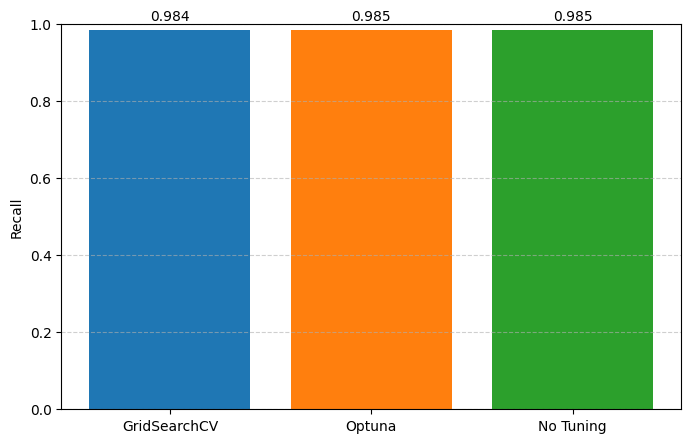

In [ ]:
# Plot
rec_series = pd.Series(rec_dict)
rec_series = rec_series.reindex(['GridSearchCV', 'Optuna', 'No Tuning'])  # konsisten urutan

plt.figure(figsize=(8,5))
bars = plt.bar(rec_series.index, rec_series.values, color=['C0','C1','C2'])
plt.ylim(0, 1)
plt.ylabel('Recall')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate values
for bar in bars:
    h = bar.get_height()
    plt.annotate(f'{h:.3f}', xy=(bar.get_x() + bar.get_width()/2, h),
                 xytext=(0,5), textcoords='offset points', ha='center', va='bottom')

plt.show()

# SAVE ALL

In [ ]:
# # Target directory
# os.makedirs('model_deploy', exist_ok=True)
# timestamp = dt.now().strftime('%d%m%Y_%H%M%S')

# # Preprocessing pipeline: MinMaxScaler, PCA, ReshapeTransformer (pkl)
# # path_prep = f'model_deploy/{timestamp}_preprocess.pkl'
# # joblib.dump(preprocess_pipeline, path_prep)
# # print("1. Preprocessing pipeline successfully saved.")

# # Reshaper for input LSTM (pkl)
# path_reshaper = f'model_deploy/{timestamp}_reshaper.pkl'
# joblib.dump(reshape_pipeline, path_reshaper)
# print("1. Reshaper has been successfully saved.")

# # LSTM Model for feature extraction (h5)
# path_lstx = f'model_deploy/{timestamp}_lstmx.h5'
# lstm_last_dense.save(path_lstx)
# print("2. LSTMX pipeline successfully saved.")

# # Hybrid LSTM-XGBoost (json)
# path_hybrid = f'model_deploy/{timestamp}_hybrid_lxgb.json'
# best_hybrid.save_model(path_hybrid)
# print("3. Hybrid model successfully saved.")

<!-- # Contoh cara pake buat prediksi -->

In [ ]:
# # --- Load semua komponen ---
# loaded_preprocessor = joblib.load(path_prep)
# loaded_feature_extractor = tf.keras.models.load_model(path_lstx)
# loaded_xgb_model = XGBClassifier()
# loaded_xgb_model.load_model(path_hybrid)


# # --- Buat fungsi prediksi end-to-end ---
# def predict_hybrid_system(data_mentah):
#     """
#     Fungsi ini menjalankan data mentah melalui seluruh alur hybrid.
#     """
#     # Pastikan input adalah 2D
#     if data_mentah.ndim == 1:
#         data_mentah = data_mentah.reshape(1, -1)
        
#     # 1. Jalankan preprocessing
#     data_processed = loaded_preprocessor.transform(data_mentah)
    
#     # 2. Ekstrak fitur dengan LSTM
#     fitur_lstm = loaded_feature_extractor.predict(data_processed)
    
#     # 3. Lakukan prediksi akhir dengan XGBoost
#     prediksi_final = loaded_xgb_model.predict(fitur_lstm)
#     probabilitas = loaded_xgb_model.predict_proba(fitur_lstm)
    
#     return prediksi_final[0], probabilitas[0]


# # --- Uji coba pada satu sampel data mentah ---
# # Ambil satu sampel dari X_test MENTAH (sebelum diproses)
# contoh_data = X_test_mentah[0] 

# hasil, prob = predict_hybrid_system(contoh_data)

# print(f"\n--- Hasil Prediksi pada Data Baru ---")
# print(f"Prediksi Kelas: {hasil} (0=Non-AF, 1=AF)")
# print(f"Probabilitas [Non-AF, AF]: [{prob[0]:.4f}, {prob[1]:.4f}]")